In [1]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import cv2
import os
import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT/MyModule')
from KDTModule import *

In [2]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

# 원본 이미지 경로
ROOT_PATH = '/Users/anhyojun/WorkSpace/LocalData/방범대'
# 회전된 이미지 경로
SAVE_PATH_90 = '/Users/anhyojun/WorkSpace/LocalData/방범대_회전'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(DS.classes)
print(f'데이터 개수 : {len(DL.dataset)}')

['맹구', '유리', '짱구', '철수', '훈이']
데이터 개수 : 25864


In [3]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]

In [4]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)

In [5]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label

In [6]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 32)
validDL = DataLoader(validDS, batch_size = 32)
testDL = DataLoader(testDS, batch_size = 32)

In [7]:
# # 이미지 회전해서 증강하기

# # 원본 이미지 경로
# ROOT_PATH = '/Users/anhyojun/WorkSpace/LocalData/방범대'
# # 회전된 이미지 경로
# SAVE_PATH_90 = '/Users/anhyojun/WorkSpace/LocalData/방범대_회전'

# # ImageFolder 사용
# DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

# originDS = datasets.ImageFolder(root=ROOT_PATH)

# for i in range(len(originDS)):
#     for j in [0, 90, 180, 270]:
#         class_name = DS.classes[DS[i][1]]
#         FILE_PATH = os.path.join(SAVE_PATH_90, class_name, f'img_index{i}_{j}.jpg')
#         FILE_PATH2 = os.path.join(SAVE_PATH_90, class_name, f'flip_img_index{i}_{j}.jpg')
#         rotate_img = originDS[i][0].rotate(j, expand=True)
#         flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
#         rotate_img.save(FILE_PATH)
#         flipped_img.save(FILE_PATH2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


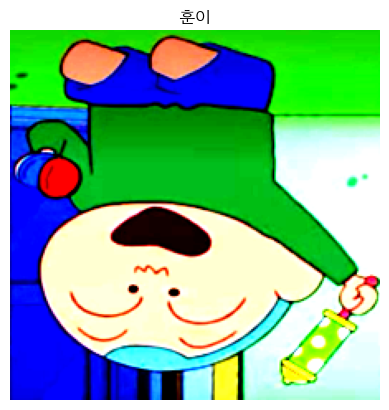

In [8]:
def draw_shin_chan(INDEX):
    name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
    plt.rc('font', family='AppleGothic')
    a = trainDL.dataset[INDEX][0].permute(1,2,0)
    plt.axis('off')
    plt.title(name_dict[trainDL.dataset[INDEX][1]])
    plt.imshow(a)
    plt.show()

draw_shin_chan(11)

In [9]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# 마지막 레이어 (full connected layer) 교체 (클래스 5개로 변경)
num_features = model.fc.in_features # 2048
model.fc = nn.Linear(num_features, 5) # 입력은 이전 층의 아웃을 그대로 받고 출력은 방법대 인원

# 손실 함수와 옵티마이저 정의
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [11]:
print(trainDL.dataset[0][0].shape)
print(trainDL.dataset[0][1])

torch.Size([3, 224, 224])
2


In [12]:
trainDL.dataset[0][0].shape

torch.Size([3, 224, 224])

In [259]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT/김소현 강사님/프로젝트/5번째 프로젝트/model'

result = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer,
                  epoch = EPOCH, endurance_cnt = 5, view_epoch = 1, num_classes = 5, SAVE_PATH = SAVE_PATH,
                  MPS = True, device = )

KeyboardInterrupt: 

In [ ]:
# 손실 및 스코어 시각화
DrawPlot(result)

In [80]:
best_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

best_model.fc = nn.Linear(best_model.fc.in_features, 5)
best_model.load_state_dict(torch.load('best_model_epoch_10.pth', weights_only=True))

<All keys matched successfully>

In [81]:
input_data = next(iter(trainDL))

In [82]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1)
pred_value

tensor([0, 3, 3, 0, 4, 3, 3, 2, 3, 4, 3, 4, 4, 2, 2, 3, 0, 1, 4, 0, 4, 4, 2, 3,
        0, 3, 3, 0, 4, 2, 4, 4])

In [83]:
real_value = input_data[1]
real_value

tensor([0, 3, 3, 3, 4, 3, 0, 2, 3, 4, 3, 4, 4, 2, 2, 3, 0, 1, 4, 0, 4, 4, 2, 3,
        0, 3, 3, 0, 4, 2, 4, 4])

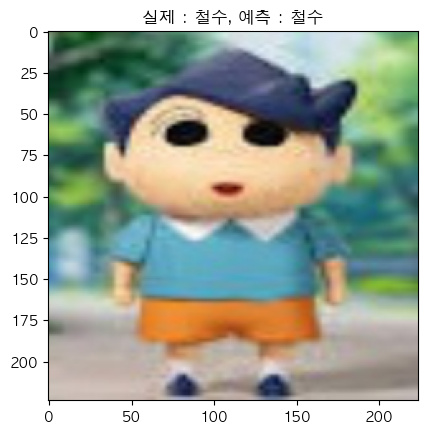

In [113]:
INDEX = 20 # 0 ~ 31

name_dict = {0 : '맹구', 1 : '유리', 2: '짱구' , 3 : '훈이', 4 : '철수'}
pred_name = name_dict[pred_value[INDEX].item()]
real_name = name_dict[input_data[1][INDEX].item()]
plt.imshow(input_data[0][INDEX].permute(1,2,0))
plt.title(f'실제 : {real_name}, 예측 : {pred_name}')
plt.show()